In [5]:
# !pip install tifffile numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from pathlib import Path
from glob import glob

# Paths you already set earlier:
base_dir = Path(Path("/Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024"))
archive_dir = base_dir / "archive"
train_health_dir = archive_dir / "train" / "health"
train_rust_dir   = archive_dir / "train" / "rust"
train_other_dir  = archive_dir / "train" / "other"
val_dir          = archive_dir / "val" / "val"

anomaly_out_dir = base_dir / "anomaly_outputs"
anomaly_out_dir.mkdir(parents=True, exist_ok=True)

# Optional: choose a subset of bands to reduce noise/compute time (None = use all)
BAND_SLICE = None  # e.g., slice(5, 110)


In [7]:
def load_tif(path):
    arr = tiff.imread(str(path))
    if arr.ndim == 2:  # (H,W)
        arr = arr[..., None]
    elif arr.ndim == 3 and arr.shape[0] < min(arr.shape[1], arr.shape[2]):  # (C,H,W) -> (H,W,C)
        arr = np.moveaxis(arr, 0, -1)
    return arr

def rx_anomaly(img):
    """
    img: (H,W,C) float
    Returns: RX anomaly map (H,W) float
    """
    H, W, C = img.shape
    X = img.reshape(-1, C).astype(np.float32)

    # Optional: select band slice
    if BAND_SLICE is not None:
        X = X[:, BAND_SLICE]

    # Standardize for stability
    X_mean = X.mean(axis=0, keepdims=True)
    X_centered = X - X_mean
    # Covariance + regularization
    cov = np.cov(X_centered, rowvar=False)
    # Add small ridge to avoid singular covariance
    cov += np.eye(cov.shape[0], dtype=np.float32) * 1e-6
    inv_cov = np.linalg.pinv(cov)  # robust pseudo-inverse

    # RX score: (x-μ)^T Σ^{-1} (x-μ)
    r = np.einsum('ij,jk,ik->i', X_centered, inv_cov, X_centered)
    r = r.reshape(H, W)

    # Normalize for visualization
    r = (r - r.min()) / (r.max() - r.min() + 1e-8)
    return r


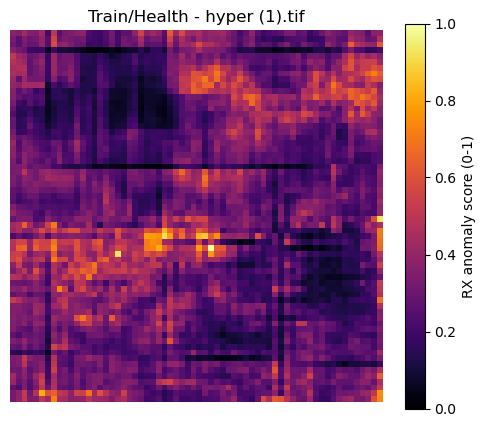

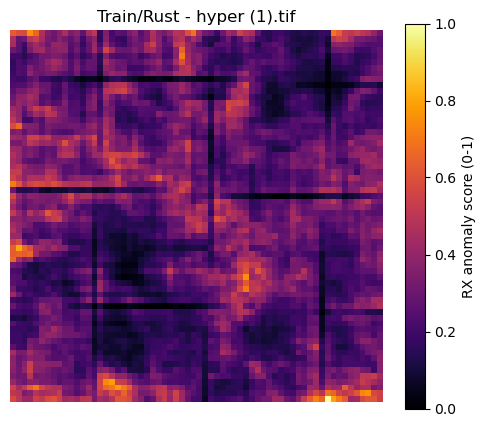

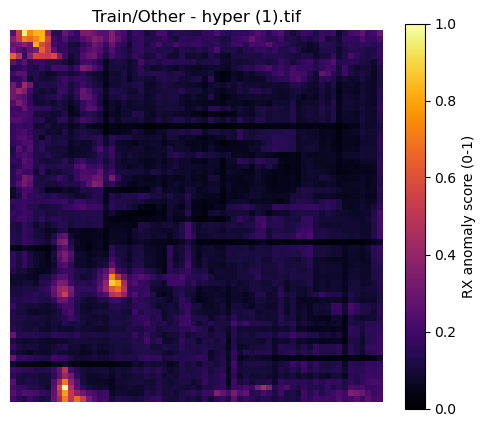

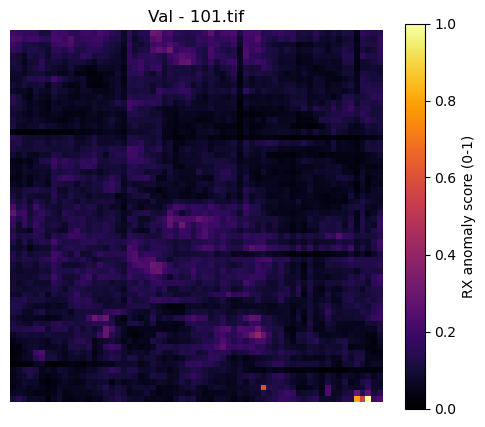

In [9]:
def preview_anomaly_from_folder(folder, title_prefix="", max_samples=1):
    paths = sorted(glob(str(folder / "*.tif")))
    if not paths:
        print("No files in", folder)
        return
    for i, p in enumerate(paths[:max_samples]):
        img = load_tif(p).astype(np.float32)
        anom = rx_anomaly(img)
        plt.figure(figsize=(6,5))
        plt.imshow(anom, cmap="inferno", vmin=0, vmax=1)
        plt.colorbar(label="RX anomaly score (0-1)")
        plt.title(f"{title_prefix} - {Path(p).name}")
        plt.axis("off")
        plt.show()

preview_anomaly_from_folder(train_health_dir, "Train/Health", 1)
preview_anomaly_from_folder(train_rust_dir,   "Train/Rust",   1)
preview_anomaly_from_folder(train_other_dir,  "Train/Other",  1)
preview_anomaly_from_folder(val_dir,          "Val",          1)


In [10]:
def batch_anomaly(src_dir, label):
    files = sorted(glob(str(src_dir / "*.tif")))
    print(f"[{label}] Processing {len(files)} files from {src_dir}")
    for p in files:
        img = load_tif(p).astype(np.float32)
        anom = rx_anomaly(img)

        # Save PNG
        out_png = anomaly_out_dir / f"{label}_{Path(p).stem}_rx.png"
        plt.figure(figsize=(6,5))
        plt.imshow(anom, cmap="inferno", vmin=0, vmax=1)
        plt.colorbar(label="RX anomaly (0-1)")
        plt.title(f"Anomaly RX - {Path(p).name}")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(out_png, dpi=150)
        plt.close()

        # Save array
        out_npy = anomaly_out_dir / f"{label}_{Path(p).stem}_rx.npy"
        np.save(out_npy, anom.astype(np.float32))

batch_anomaly(train_health_dir, "train_health")
batch_anomaly(train_rust_dir,   "train_rust")
batch_anomaly(train_other_dir,  "train_other")
batch_anomaly(val_dir,          "val")
print("Saved anomaly maps to:", anomaly_out_dir)


[train_health] Processing 200 files from /Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024/archive/train/health
[train_rust] Processing 200 files from /Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024/archive/train/rust
[train_other] Processing 200 files from /Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024/archive/train/other
[val] Processing 300 files from /Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024/archive/val/val
Saved anomaly maps to: /Users/gauravvaru/Documents/Automated-Crop-Disease-Diagnosis-from-Hyperspectral-Imagery-3rd/beyond-visible-spectrum-ai-for-agriculture-2024/anomaly_outputs


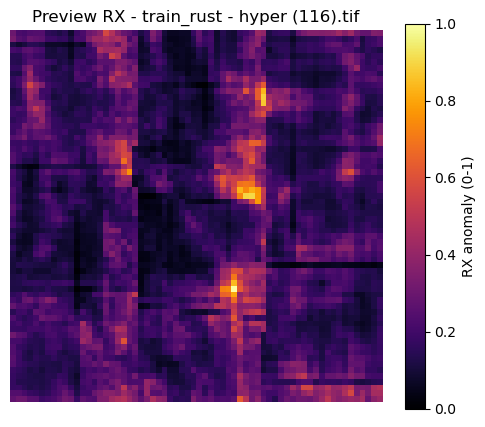

In [13]:
target_split = "train_rust"  # train_health | train_rust | train_other | val
file_index   = 19            # 0-based index

folder_map = {
    "train_health": train_health_dir,
    "train_rust":   train_rust_dir,
    "train_other":  train_other_dir,
    "val":          val_dir,
}
src_dir = folder_map[target_split]
paths = sorted(glob(str(src_dir / "*.tif")))
p = Path(paths[file_index])

img = load_tif(p).astype(np.float32)
anom = rx_anomaly(img)

plt.figure(figsize=(6,5))
plt.imshow(anom, cmap="inferno", vmin=0, vmax=1)
plt.colorbar(label="RX anomaly (0-1)")
plt.title(f"Preview RX - {target_split} - {p.name}")
plt.axis("off")
plt.show()
